In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from reservoirpy.nodes import Reservoir, Ridge, ESN
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EMBEDDING_SIZE = 128  
NUM_HEADS = 4
NUM_LAYERS = 4
DROPOUT = 0.1
LEARNING_RATE = 1e-4
EPOCHS = 16
PATIENCE = 5

In [3]:
def load_data():
    partOfData = 1
    X_genres = pd.read_csv("../data/train/input_genres_tags_data.csv")
    X_instruments = pd.read_csv("../data/train/input_instruments_tags_data.csv")
    X_moods = pd.read_csv("../data/train/input_moods_tags_data.csv")

    y_genres = pd.read_csv("../data/train/output_genres_tags_data.csv")
    y_instruments = pd.read_csv("../data/train/output_instruments_tags_data.csv")
    y_moods = pd.read_csv("../data/train/output_moods_tags_data.csv")

    # On peut garder seulement une partie des données
    X_genres = X_genres[: int(partOfData * len(X_genres))]
    X_instruments = X_instruments[: int(partOfData * len(X_instruments))]
    X_moods = X_moods[: int(partOfData * len(X_moods))]
    y_genres = y_genres[: int(partOfData * len(y_genres))]
    y_instruments = y_instruments[: int(partOfData * len(y_instruments))]
    y_moods = y_moods[: int(partOfData * len(y_moods))]

    return (X_genres, X_instruments, X_moods), (y_genres, y_instruments, y_moods)


# Ensure the input data is in the correct format
def reshape_input(X):
    if isinstance(X, pd.DataFrame):
        return X.values.reshape(-1, 1, X.shape[1])  # Handles pandas DataFrame
    elif isinstance(X, np.ndarray):
        return X.reshape(-1, 1, X.shape[1])  # Handles numpy ndarray
    else:
        raise ValueError("Input must be a pandas DataFrame or a numpy ndarray")


def format_predictions(predictions):
    # Convert the list to a NumPy array
    predictions_array = np.array(predictions)

    # Reshape the array to 2-dimensional
    predictions_reshaped = predictions_array.reshape(-1, predictions_array.shape[-1])

    return predictions_reshaped

In [4]:
# Charger les données
(X_genres, X_instruments, X_moods), (y_genres, y_instruments, y_moods) = load_data()

# Train-test split
X_genres_train, X_genres_test, y_genres_train, y_genres_test = train_test_split(
    X_genres, y_genres, test_size=0.2, random_state=42
)
X_instruments_train, X_instruments_test, y_instruments_train, y_instruments_test = (
    train_test_split(X_instruments, y_instruments, test_size=0.2, random_state=42)
)
X_moods_train, X_moods_test, y_moods_train, y_moods_test = train_test_split(
    X_moods, y_moods, test_size=0.2, random_state=42
)

In [5]:
# Préparation des données
X_genres_train = X_genres_train.drop(columns=["ChallengeID"])
X_instruments_train = X_instruments_train.drop(columns=["ChallengeID"])
X_moods_train = X_moods_train.drop(columns=["ChallengeID"])
y_genres_train = y_genres_train.drop(columns=["ChallengeID"])
y_instruments_train = y_instruments_train.drop(columns=["ChallengeID"])
y_moods_train = y_moods_train.drop(columns=["ChallengeID"])

X_genres_test = X_genres_test.drop(columns=["ChallengeID"])
X_instruments_test = X_instruments_test.drop(columns=["ChallengeID"])
X_moods_test = X_moods_test.drop(columns=["ChallengeID"])
y_genres_test = y_genres_test.drop(columns=["ChallengeID"])
y_instruments_test = y_instruments_test.drop(columns=["ChallengeID"])
y_moods_test = y_moods_test.drop(columns=["ChallengeID"])


X_train = np.concatenate([X_genres_train, X_instruments_train, X_moods_train], axis=1)
X_test = np.concatenate([X_genres_test, X_instruments_test, X_moods_test], axis=1)

y_train = np.concatenate([y_genres_train, y_instruments_train, y_moods_train], axis=1)
y_test = np.concatenate([y_genres_test, y_instruments_test, y_moods_test], axis=1)

# Convertir les données en tensors PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(DEVICE)

# Générer les données croisées pour les interactions
X_genres_instruments_train = np.concatenate(
    [X_genres_train, X_instruments_train], axis=1
)
X_genres_moods_train = np.concatenate([X_genres_train, X_moods_train], axis=1)
X_instruments_moods_train = np.concatenate([X_instruments_train, X_moods_train], axis=1)
y_genres_instruments_train = np.concatenate(
    [y_genres_train, y_instruments_train], axis=1
)
y_genres_moods_train = np.concatenate([y_genres_train, y_moods_train], axis=1)
y_instruments_moods_train = np.concatenate([y_instruments_train, y_moods_train], axis=1)

X_genres_instruments_test = np.concatenate([X_genres_test, X_instruments_test], axis=1)
X_genres_moods_test = np.concatenate([X_genres_test, X_moods_test], axis=1)
X_instruments_moods_test = np.concatenate([X_instruments_test, X_moods_test], axis=1)
y_genres_instruments_test = np.concatenate([y_genres_test, y_instruments_test], axis=1)
y_genres_moods_test = np.concatenate([y_genres_test, y_moods_test], axis=1)
y_instruments_moods_test = np.concatenate([y_instruments_test, y_moods_test], axis=1)


In [6]:
# Initialisation des réservoirs (genre, instrument, mood)
reservoir_Genre = Reservoir(
    units=100,
    sr=0,  # Spectral radius
    lr=1,  # Leak rate
    input_scaling=1.0,
)

reservoir_Instrument = Reservoir(units=100, sr=0, lr=1, input_scaling=1.0)

reservoir_Mood = Reservoir(units=100, sr=0, lr=1, input_scaling=1.0)

# Readout pour chaque réservoir
readout_Genre = Ridge(ridge=1e-4)
readout_Instrument = Ridge(ridge=1e-4)
readout_Mood = Ridge(ridge=1e-4)

# Création des modèles avec ESN (Echo State Network)
model_Genre = ESN(reservoir=reservoir_Genre, readout=readout_Genre, workers=-1)
model_Instrument = ESN(
    reservoir=reservoir_Instrument, readout=readout_Instrument, workers=-1
)
model_Mood = ESN(reservoir=reservoir_Mood, readout=readout_Mood, workers=-1)

# Réservoirs pour les interactions croisées
reservoir_Genre_Instrument = Reservoir(units=100, sr=0, lr=1, input_scaling=1.0)
reservoir_Genre_Mood = Reservoir(units=100, sr=0, lr=1, input_scaling=1.0)
reservoir_Instrument_Mood = Reservoir(units=100, sr=0, lr=1, input_scaling=1.0)

# Readouts pour ces réservoirs
readout_Genre_Instrument = Ridge(ridge=1e-4)
readout_Genre_Mood = Ridge(ridge=1e-4)
readout_Instrument_Mood = Ridge(ridge=1e-4)

# Modèles ESN pour les interactions croisées
model_Genre_Instrument = ESN(
    reservoir=reservoir_Genre_Instrument, readout=readout_Genre_Instrument, workers=-1
)
model_Genre_Mood = ESN(
    reservoir=reservoir_Genre_Mood, readout=readout_Genre_Mood, workers=-1
)
model_Instrument_Mood = ESN(
    reservoir=reservoir_Instrument_Mood, readout=readout_Instrument_Mood, workers=-1
)

In [7]:
X_genres_train_reshaped = reshape_input(X_genres_train)
X_instruments_train_reshaped = reshape_input(X_instruments_train)
X_moods_train_reshaped = reshape_input(X_moods_train)

y_genres_train_reshaped = reshape_input(y_genres_train)
y_instruments_train_reshaped = reshape_input(y_instruments_train)
y_moods_train_reshaped = reshape_input(y_moods_train)

X_genres_test_reshaped = reshape_input(X_genres_test)
X_instruments_test_reshaped = reshape_input(X_instruments_test)
X_moods_test_reshaped = reshape_input(X_moods_test)

y_genres_test_reshaped = reshape_input(y_genres_test)
y_instruments_test_reshaped = reshape_input(y_instruments_test)
y_moods_test_reshaped = reshape_input(y_moods_test)


# Entraîner les réservoirs
# Train the models with one line for single timestep
model_Genre.fit(X_genres_train_reshaped, y_genres_train_reshaped)
model_Instrument.fit(X_instruments_train_reshaped, y_instruments_train_reshaped)
model_Mood.fit(X_moods_train_reshaped, y_moods_train_reshaped)


# Reshape les données croisées pour les ESNs
X_genres_instruments_train_reshaped = reshape_input(X_genres_instruments_train)
X_genres_moods_train_reshaped = reshape_input(X_genres_moods_train)
X_instruments_moods_train_reshaped = reshape_input(X_instruments_moods_train)

y_genres_instruments_train_reshaped = reshape_input(y_genres_instruments_train)
y_genres_moods_train_reshaped = reshape_input(y_genres_moods_train)
y_instruments_moods_train_reshaped = reshape_input(y_instruments_moods_train)

X_genres_instruments_test_reshaped = reshape_input(X_genres_instruments_test)
X_genres_moods_test_reshaped = reshape_input(X_genres_moods_test)
X_instruments_moods_test_reshaped = reshape_input(X_instruments_moods_test)

y_genres_instruments_test_reshaped = reshape_input(y_genres_instruments_test)
y_genres_moods_test_reshaped = reshape_input(y_genres_moods_test)
y_instruments_moods_test_reshaped = reshape_input(y_instruments_moods_test)

# Entraîner les ESNs
model_Genre_Instrument.fit(
    X_genres_instruments_train_reshaped, y_genres_instruments_train_reshaped
)
model_Genre_Mood.fit(X_genres_moods_train_reshaped, y_genres_moods_train_reshaped)
model_Instrument_Mood.fit(
    X_instruments_moods_train_reshaped, y_instruments_moods_train_reshaped
)

Running ESN-0: 100%|██████████| 88683/88683 [00:10<00:00, 8759.63it/s] 


Fitting node ESN-0...


Running ESN-1: 100%|██████████| 88683/88683 [00:09<00:00, 9203.12it/s] 


Fitting node ESN-1...


Running ESN-2: 100%|██████████| 88683/88683 [00:10<00:00, 8300.35it/s]


Fitting node ESN-2...


Running ESN-3: 100%|██████████| 88683/88683 [00:14<00:00, 6238.86it/s]


Fitting node ESN-3...


Running ESN-4: 100%|██████████| 88683/88683 [00:13<00:00, 6819.91it/s]


Fitting node ESN-4...


Running ESN-5: 100%|██████████| 88683/88683 [00:13<00:00, 6646.86it/s]


Fitting node ESN-5...


'ESN-5': ESN('Reservoir-5', 'Ridge-5')

In [8]:
# Obtenir les sorties des réservoirs
y_genres_train_pred = model_Genre.run(X_genres_train_reshaped)
y_instruments_train_pred = model_Instrument.run(X_instruments_train_reshaped)
y_moods_train_pred = model_Mood.run(X_moods_train_reshaped)

y_genres_test_pred = model_Genre.run(X_genres_test_reshaped)
y_instruments_test_pred = model_Instrument.run(X_instruments_test_reshaped)
y_moods_test_pred = model_Mood.run(X_moods_test_reshaped)

# Formater les prédictions
y_genres_train_pred = format_predictions(y_genres_train_pred)
y_instruments_train_pred = format_predictions(y_instruments_train_pred)
y_moods_train_pred = format_predictions(y_moods_train_pred)

y_genres_test_pred = format_predictions(y_genres_test_pred)
y_instruments_test_pred = format_predictions(y_instruments_test_pred)
y_moods_test_pred = format_predictions(y_moods_test_pred)


# Obtenir les sorties des réservoirs croisés
y_genres_instruments_train_pred = model_Genre_Instrument.run(
    X_genres_instruments_train_reshaped
)
y_genres_moods_train_pred = model_Genre_Mood.run(X_genres_moods_train_reshaped)
y_instruments_moods_train_pred = model_Instrument_Mood.run(
    X_instruments_moods_train_reshaped
)

y_genres_instruments_test_pred = model_Genre_Instrument.run(
    X_genres_instruments_test_reshaped
)
y_genres_moods_test_pred = model_Genre_Mood.run(X_genres_moods_test_reshaped)
y_instruments_moods_test_pred = model_Instrument_Mood.run(
    X_instruments_moods_test_reshaped
)

# Formater les prédictions
y_genres_instruments_train_pred = format_predictions(y_genres_instruments_train_pred)
y_genres_moods_train_pred = format_predictions(y_genres_moods_train_pred)
y_instruments_moods_train_pred = format_predictions(y_instruments_moods_train_pred)

y_genres_instruments_test_pred = format_predictions(y_genres_instruments_test_pred)
y_genres_moods_test_pred = format_predictions(y_genres_moods_test_pred)
y_instruments_moods_test_pred = format_predictions(y_instruments_moods_test_pred)


# Combine all outputs (individual and cross) into a dictionary
X_train_final = {
    "X_genres": X_genres_train,
    "X_instruments": X_instruments_train,
    "X_moods": X_moods_train,
    "y_genres_pred": y_genres_train_pred,
    "y_instruments_pred": y_instruments_train_pred,
    "y_moods_pred": y_moods_train_pred,
    "y_genres_instruments_pred": y_genres_instruments_train_pred,
    "y_genres_moods_pred": y_genres_moods_train_pred,
    "y_instruments_moods_pred": y_instruments_moods_train_pred,
}

X_test_final = {
    "X_genres": X_genres_test,
    "X_instruments": X_instruments_test,
    "X_moods": X_moods_test,
    "y_genres_pred": y_genres_test_pred,
    "y_instruments_pred": y_instruments_test_pred,
    "y_moods_pred": y_moods_test_pred,
    "y_genres_instruments_pred": y_genres_instruments_test_pred,
    "y_genres_moods_pred": y_genres_moods_test_pred,
    "y_instruments_moods_pred": y_instruments_moods_test_pred,
}



Running ESN-5: 100%|██████████| 22171/22171 [00:00<00:00, 25882.77it/s]


In [9]:
# Define input sizes for the embeddings
input_size_dict = {
    "X_genres": X_genres_train.shape[1],
    "X_instruments": X_instruments_train.shape[1],
    "X_moods": X_moods_train.shape[1],
    "y_genres_pred": y_genres_train_pred.shape[1],
    "y_instruments_pred": y_instruments_train_pred.shape[1],
    "y_moods_pred": y_moods_train_pred.shape[1],
    "y_genres_instruments_pred": y_genres_instruments_train_pred.shape[1],
    "y_genres_moods_pred": y_genres_moods_train_pred.shape[1],
    "y_instruments_moods_pred": y_instruments_moods_train_pred.shape[1],
}

# Define the output size
output_size_dict = {
    "y_genres": y_genres_train.shape[1],
    "y_instruments": y_instruments_train.shape[1],
    "y_moods": y_moods_train.shape[1],
}

In [10]:
# Display the shapes of the inputs and outputs
for key, value in input_size_dict.items():
    print(f"{key}: {value}")

for key, value in output_size_dict.items():
    print(f"{key}: {value}")

X_genres: 90
X_instruments: 112
X_moods: 46
y_genres_pred: 90
y_instruments_pred: 112
y_moods_pred: 46
y_genres_instruments_pred: 202
y_genres_moods_pred: 136
y_instruments_moods_pred: 158
y_genres: 90
y_instruments: 112
y_moods: 46


In [19]:
# Fraction de données pour la validation
VALIDATION_SPLIT = 0.2

# Division des données en entraînement et validation pour chaque entrée
X_train_final_train = {}
X_train_final_val = {}

for key, value in X_train_final.items():
    X_train_final_train[key], X_train_final_val[key] = train_test_split(
        value, test_size=VALIDATION_SPLIT, random_state=42
    )

# Convert DataFrames to NumPy arrays if necessary
for key in X_train_final_train:
    if isinstance(X_train_final_train[key], pd.DataFrame):
        X_train_final_train[key] = X_train_final_train[key].values
    if isinstance(X_train_final_val[key], pd.DataFrame):
        X_train_final_val[key] = X_train_final_val[key].values

for key in X_test_final:
    if isinstance(X_test_final[key], pd.DataFrame):
        X_test_final[key] = X_test_final[key].values


# Prepare the predicted outputs from reservoirs as tensors
def prepare_tensors(data_dict, device):
    for key in data_dict:
        if isinstance(data_dict[key], pd.DataFrame):
            data_dict[key] = torch.tensor(data_dict[key].values, dtype=torch.float32).to(device)
        else:
            data_dict[key] = torch.tensor(data_dict[key], dtype=torch.float32).to(device)
    return data_dict

X_train_final_train = prepare_tensors(X_train_final_train, DEVICE)
X_train_final_val = prepare_tensors(X_train_final_val, DEVICE)
X_test_final = prepare_tensors(X_test_final, DEVICE)

# Création des datasets
def create_dataset(X_data, y_data, device):
    return torch.utils.data.TensorDataset(
        X_data["X_genres"],
        X_data["X_instruments"],
        X_data["X_moods"],
        X_data["y_genres_pred"],
        X_data["y_instruments_pred"],
        X_data["y_moods_pred"],
        X_data["y_genres_instruments_pred"],
        X_data["y_genres_moods_pred"],
        X_data["y_instruments_moods_pred"],
        y_data,
    )

train_dataset = create_dataset(X_train_final_train, y_train_tensor[: len(X_train_final_train["X_genres"])], DEVICE)
val_dataset = create_dataset(X_train_final_val, y_train_tensor[len(X_train_final_train["X_genres"]) :], DEVICE)
test_dataset = create_dataset(X_test_final, y_test_tensor, DEVICE)

# Création des loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_405014/905551653.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict[key] = torch.tensor(data_dict[key], dtype=torch.float32).to(device)


In [20]:
train_dataset.tensors[0].shape, train_dataset.tensors[1].shape

(torch.Size([70946, 90]), torch.Size([70946, 112]))

In [13]:
# Modèle de Transformeur
class MultiTaskTransformer(nn.Module):
    def __init__(self, embedding_size, num_heads, num_layers, num_labels, dropout):
        super(MultiTaskTransformer, self).__init__()
        self.embedding_genres = nn.Linear(input_size_dict["X_genres"], embedding_size)
        self.embedding_instruments = nn.Linear(input_size_dict["X_instruments"], embedding_size)
        self.embedding_moods = nn.Linear(input_size_dict["X_moods"], embedding_size)
        self.embedding_y_genres_pred = nn.Linear(input_size_dict["y_genres_pred"], embedding_size)
        self.embedding_y_instruments_pred = nn.Linear(
            input_size_dict["y_instruments_pred"], embedding_size
        )
        self.embedding_y_moods_pred = nn.Linear(input_size_dict["y_moods_pred"], embedding_size)
        self.embedding_y_genres_instruments_pred = nn.Linear(input_size_dict["y_genres_instruments_pred"], embedding_size)
        self.embedding_y_genres_moods_pred = nn.Linear(input_size_dict["y_genres_moods_pred"], embedding_size)
        self.embedding_y_instruments_moods_pred = nn.Linear(input_size_dict["y_instruments_moods_pred"], embedding_size)
        self.transformer = nn.Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.classifier = nn.Linear(embedding_size, num_labels)

    def forward(
        self,
        x_genres,
        x_instruments,
        x_moods,
        y_genres_pred,
        y_instruments_pred,
        y_moods_pred,
        y_genres_instruments_pred,
        y_genres_moods_pred,
        y_instruments_moods_pred,
    ):
        embedded_genres = self.embedding_genres(x_genres)
        embedded_instruments = self.embedding_instruments(x_instruments)
        embedded_moods = self.embedding_moods(x_moods)
        embedded_y_genres_pred = self.embedding_y_genres_pred(y_genres_pred)
        embedded_y_instruments_pred = self.embedding_y_instruments_pred(
            y_instruments_pred
        )
        embedded_y_moods_pred = self.embedding_y_moods_pred(y_moods_pred)
        embedded_y_genres_instruments_pred = self.embedding_y_genres_instruments_pred(y_genres_instruments_pred)
        embedded_y_genres_moods_pred = self.embedding_y_genres_moods_pred(y_genres_moods_pred)
        embedded_y_instruments_moods_pred = self.embedding_y_instruments_moods_pred(y_instruments_moods_pred)

        
        sequence = torch.stack(
            [
                embedded_genres,
                embedded_instruments,
                embedded_moods,
                embedded_y_genres_pred,
                embedded_y_instruments_pred,
                embedded_y_moods_pred,
                embedded_y_genres_instruments_pred,
                embedded_y_genres_moods_pred,
                embedded_y_instruments_moods_pred,
            ],
            dim=1,
        )

        transformer_output = self.transformer(sequence, sequence)
        output = transformer_output.mean(dim=1)
        predictions = self.classifier(output)
        return predictions


# Initialiser le modèle
model = MultiTaskTransformer(
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_labels=y_train.shape[1], 
    dropout=DROPOUT,
).to(DEVICE)

# Affichage du nombre de paramètres
print(f"Nombre total de paramètres : {sum(p.numel() for p in model.parameters())}")

# Optimiseur et fonction de perte
criterion = nn.BCEWithLogitsLoss()  # Fonction de perte pour les étiquettes binaires
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Nombre total de paramètres : 5074040


In [21]:
class MultiTaskTransformer(nn.Module):
    def __init__(self, input_size_dict, embedding_size, num_heads, num_layers, num_labels, dropout):
        super(MultiTaskTransformer, self).__init__()
        
        # Parallel input embeddings
        self.embeddings = nn.ModuleDict({
            'genres': nn.Sequential(
                nn.Linear(input_size_dict["X_genres"], embedding_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ),
            'instruments': nn.Sequential(
                nn.Linear(input_size_dict["X_instruments"], embedding_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ),
            'moods': nn.Sequential(
                nn.Linear(input_size_dict["X_moods"], embedding_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
        })
        
        # Prediction embeddings
        self.prediction_embeddings = nn.ModuleDict({
            'y_genres_pred': nn.Sequential(
                nn.Linear(input_size_dict["y_genres_pred"], embedding_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ),
            'y_instruments_pred': nn.Sequential(
                nn.Linear(input_size_dict["y_instruments_pred"], embedding_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ),
            'y_moods_pred': nn.Sequential(
                nn.Linear(input_size_dict["y_moods_pred"], embedding_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ),
            'y_genres_instruments_pred': nn.Sequential(
                nn.Linear(input_size_dict["y_genres_instruments_pred"], embedding_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ),
            'y_genres_moods_pred': nn.Sequential(
                nn.Linear(input_size_dict["y_genres_moods_pred"], embedding_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ),
            'y_instruments_moods_pred': nn.Sequential(
                nn.Linear(input_size_dict["y_instruments_moods_pred"], embedding_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
        })
        
        # Cross-attention mechanism
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=embedding_size, 
            num_heads=num_heads, 
            dropout=dropout,
            batch_first=True
        )
        
        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size, 
                nhead=num_heads,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(embedding_size, embedding_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_size // 2, num_labels)
        )

    def forward(
        self,
        x_genres,
        x_instruments,
        x_moods,
        y_genres_pred,
        y_instruments_pred,
        y_moods_pred,
        y_genres_instruments_pred,
        y_genres_moods_pred,
        y_instruments_moods_pred
    ):
        # Embed input features
        embedded_inputs = torch.stack([
            self.embeddings['genres'](x_genres),
            self.embeddings['instruments'](x_instruments),
            self.embeddings['moods'](x_moods)
        ], dim=1)
        
        # Embed prediction features
        embedded_predictions = torch.stack([
            self.prediction_embeddings['y_genres_pred'](y_genres_pred),
            self.prediction_embeddings['y_instruments_pred'](y_instruments_pred),
            self.prediction_embeddings['y_moods_pred'](y_moods_pred),
            self.prediction_embeddings['y_genres_instruments_pred'](y_genres_instruments_pred),
            self.prediction_embeddings['y_genres_moods_pred'](y_genres_moods_pred),
            self.prediction_embeddings['y_instruments_moods_pred'](y_instruments_moods_pred)
        ], dim=1)
        
        # Combine inputs
        combined_sequence = torch.cat([embedded_inputs, embedded_predictions], dim=1)
        
        # Apply cross-attention
        attended_sequence, _ = self.cross_attention(combined_sequence, combined_sequence, combined_sequence)
        
        # Transformer encoder
        encoded_sequence = self.transformer_encoder(attended_sequence)
        
        # Global average pooling
        pooled_output = encoded_sequence.mean(dim=1)
        
        # Final classification
        predictions = self.classifier(pooled_output)
        
        return predictions
    

model = MultiTaskTransformer(
    input_size_dict=input_size_dict, 
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_labels=y_train.shape[1],
    dropout=DROPOUT
).to(DEVICE)

# Optimizer and loss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [22]:
# Entraînement
def train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs, patience
):
    """
    Entraîne un modèle avec early stopping.

    Args:
        model: Le modèle à entraîner.
        train_loader: DataLoader pour les données d'entraînement.
        val_loader: DataLoader pour les données de validation.
        criterion: Fonction de perte.
        optimizer: Optimiseur.
        epochs: Nombre maximum d'époques.
        patience: Nombre d'époques à attendre pour une amélioration avant d'arrêter l'entraînement.

    Returns:
        Le meilleur modèle basé sur les performances sur l'ensemble de validation.
    """
    best_loss = float("inf")
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        epoch_loss = 0.0
        for (
            x_genres_batch,
            x_instruments_batch,
            x_moods_batch,
            y_genres_pred_batch,
            y_instruments_pred_batch,
            y_moods_pred_batch,
            y_genres_instruments_pred_batch,
            y_genres_moods_pred_batch,
            y_instruments_moods_pred_batch,
            y_batch,
        ) in train_loader:
            optimizer.zero_grad()
            predictions = model(
                x_genres_batch,
                x_instruments_batch,
                x_moods_batch,
                y_genres_pred_batch,
                y_instruments_pred_batch,
                y_moods_pred_batch,
                y_genres_instruments_pred_batch,
                y_genres_moods_pred_batch,
                y_instruments_moods_pred_batch,
            )
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss = epoch_loss / len(train_loader)

        # Mode validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (
                x_genres_batch,
                x_instruments_batch,
                x_moods_batch,
                y_genres_pred_batch,
                y_instruments_pred_batch,
                y_moods_pred_batch,
                y_genres_instruments_pred_batch,
                y_genres_moods_pred_batch,
                y_instruments_moods_pred_batch,
                y_batch,
            ) in val_loader:
                predictions = model(
                    x_genres_batch,
                    x_instruments_batch,
                    x_moods_batch,
                    y_genres_pred_batch,
                    y_instruments_pred_batch,
                    y_moods_pred_batch,
                    y_genres_instruments_pred_batch,
                    y_genres_moods_pred_batch,
                    y_instruments_moods_pred_batch,
                )
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(
                f"Early stopping triggered at epoch {epoch + 1}. Best validation loss: {best_loss:.4f}"
            )
            break

    # Charger le meilleur modèle
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model


# Évaluation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for (
            x_genres_batch,
            x_instruments_batch,
            x_moods_batch,
            y_genres_pred_batch,
            y_instruments_pred_batch,
            y_moods_pred_batch,
            y_genres_instruments_pred_batch,
            y_genres_moods_pred_batch,
            y_instruments_moods_pred_batch,
            y_batch,
        ) in test_loader:
            predictions = model(
                x_genres_batch,
                x_instruments_batch,
                x_moods_batch,
                y_genres_pred_batch,
                y_instruments_pred_batch,
                y_moods_pred_batch,
                y_genres_instruments_pred_batch,
                y_genres_moods_pred_batch,
                y_instruments_moods_pred_batch,
            )
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    print(f"Test Loss: {total_loss / len(test_loader)}")

In [24]:
evaluate_model(model, test_loader, criterion)

Test Loss: 0.12815214534657832


In [23]:
# Entraîner le modèle
train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, PATIENCE)

# Évaluer le modèle
# evaluate_model(model, test_loader, criterion)

Epoch 1/16, Train Loss: 0.1925, Val Loss: 0.1277
Epoch 2/16, Train Loss: 0.1318, Val Loss: 0.1274
Epoch 3/16, Train Loss: 0.1304, Val Loss: 0.1275
Epoch 4/16, Train Loss: 0.1298, Val Loss: 0.1274
Epoch 5/16, Train Loss: 0.1294, Val Loss: 0.1274
Epoch 6/16, Train Loss: 0.1292, Val Loss: 0.1274
Epoch 7/16, Train Loss: 0.1290, Val Loss: 0.1273
Epoch 8/16, Train Loss: 0.1288, Val Loss: 0.1274
Epoch 9/16, Train Loss: 0.1287, Val Loss: 0.1273
Epoch 10/16, Train Loss: 0.1286, Val Loss: 0.1275
Epoch 11/16, Train Loss: 0.1286, Val Loss: 0.1273
Epoch 12/16, Train Loss: 0.1285, Val Loss: 0.1273
Epoch 13/16, Train Loss: 0.1285, Val Loss: 0.1273
Epoch 14/16, Train Loss: 0.1284, Val Loss: 0.1273
Epoch 15/16, Train Loss: 0.1284, Val Loss: 0.1273
Epoch 16/16, Train Loss: 0.1284, Val Loss: 0.1273


MultiTaskTransformer(
  (embeddings): ModuleDict(
    (genres): Sequential(
      (0): Linear(in_features=90, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (instruments): Sequential(
      (0): Linear(in_features=112, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (moods): Sequential(
      (0): Linear(in_features=46, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
  )
  (prediction_embeddings): ModuleDict(
    (y_genres_pred): Sequential(
      (0): Linear(in_features=90, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (y_instruments_pred): Sequential(
      (0): Linear(in_features=112, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (y_moods_pred): Sequential(
      (0): Linear(in_features=46, out_features=128, bias=True)
      (1): ReLU()

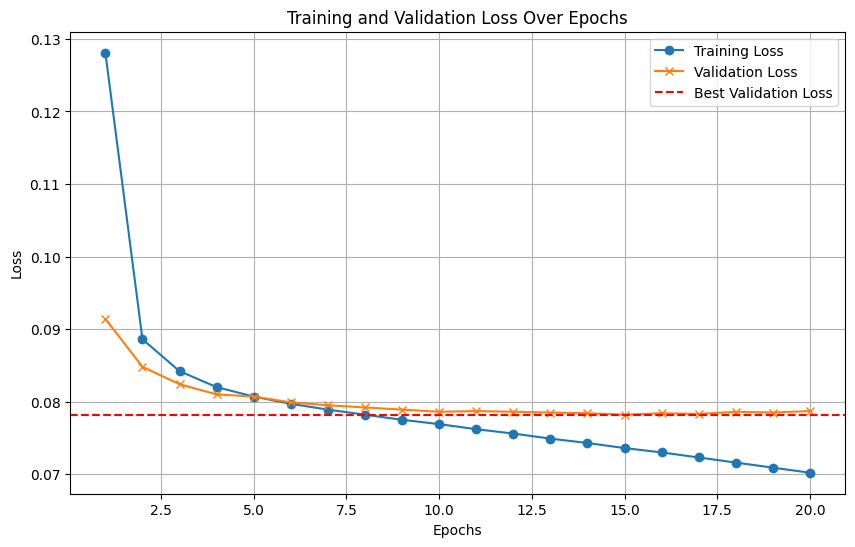

In [ ]:
import matplotlib.pyplot as plt

# Data from the training log
epochs = list(range(1, 21))
train_loss = [
    0.1281,
    0.0886,
    0.0842,
    0.0820,
    0.0807,
    0.0797,
    0.0789,
    0.0782,
    0.0775,
    0.0769,
    0.0762,
    0.0756,
    0.0749,
    0.0743,
    0.0736,
    0.0730,
    0.0723,
    0.0716,
    0.0709,
    0.0702,
]
val_loss = [
    0.0914,
    0.0848,
    0.0824,
    0.0810,
    0.0807,
    0.0799,
    0.0795,
    0.0792,
    0.0789,
    0.0786,
    0.0787,
    0.0786,
    0.0785,
    0.0784,
    0.0782,
    0.0784,
    0.0783,
    0.0786,
    0.0785,
    0.0787,
]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="x")
plt.axhline(y=0.0782, color="r", linestyle="--", label="Best Validation Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# Evaluation des performances (accuracy, precision, recall, f1-score)
def evaluate_performance(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for (
            x_genres_batch,
            x_instruments_batch,
            x_moods_batch,
            y_genres_pred_batch,
            y_instruments_pred_batch,
            y_moods_pred_batch,
            y_genres_instruments_pred_batch,
            y_genres_moods_pred_batch,
            y_instruments_moods_pred_batch,
            y_batch
        ) in test_loader:
            predictions = model(
                x_genres_batch,
                x_instruments_batch,
                x_moods_batch,
                y_genres_pred_batch,
                y_instruments_pred_batch,
                y_moods_pred_batch,
                y_genres_instruments_pred_batch,
                y_genres_moods_pred_batch,
                y_instruments_moods_pred_batch,
            )
            predictions = torch.sigmoid(predictions)
            predictions = (predictions > 0.5).int()
            y_true.append(y_batch.cpu().numpy())
            y_pred.append(predictions.cpu().numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    # Save 5% of the rows of the predictions as csv files in the data folder in predictions folder
    # np.savetxt(
    #     "../data/predictions/train/y_true.csv",
    #     y_true[: int(0.05 * len(y_true))],
    #     delimiter=",",
    # )
    # np.savetxt(
    #     "../data/predictions/train/y_pred.csv",
    #     y_pred[: int(0.05 * len(y_pred))],
    #     delimiter=",",
    # )

    # Histograms plot of the predictions and true values for each tag
    # for i in range(y_true.shape[1]):
    #     plt.hist(y_true[:, i], bins=2, alpha=0.5, label="True")
    #     plt.hist(y_pred[:, i], bins=2, alpha=0.5, label="Predicted")
    #     plt.title(f"Tag {i}")
    #     plt.legend()
    #     plt.savefig(f"../data/predictions/train/histogram_tag_{i}.png")
    #     plt.clf()

    # Accuracy
    accuracy = np.mean(y_true == y_pred)
    print(f"Accuracy: {accuracy}")

    # Precision, Recall, F1-Score
    from sklearn.metrics import classification_report

    report = classification_report(y_true, y_pred, digits=4)
    print(report)


In [26]:
# Evaluer les performances pour test_loader combiné avec le train_loader

# Combine les loaders
# combined_loader = torch.utils.data.DataLoader(
#     torch.utils.data.ConcatDataset([train_dataset, test_dataset, val_dataset]),
#     batch_size=BATCH_SIZE,
#     shuffle=False,
# )

evaluate_performance(model, train_loader)


Accuracy: 0.9637978862615183
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       572
           1     0.0000    0.0000    0.0000      3960
           2     0.0000    0.0000    0.0000       814
           3     0.0000    0.0000    0.0000       267
           4     0.0000    0.0000    0.0000       209
           5     0.0000    0.0000    0.0000       944
           6     0.0000    0.0000    0.0000       400
           7     0.0000    0.0000    0.0000      1626
           8     0.0000    0.0000    0.0000      3264
           9     0.0000    0.0000    0.0000       723
          10     0.0000    0.0000    0.0000      2410
          11     0.0000    0.0000    0.0000      6622
          12     0.0000    0.0000    0.0000      1415
          13     0.0000    0.0000    0.0000      4489
          14     0.0000    0.0000    0.0000      2949
          15     0.0000    0.0000    0.0000      1168
          16     0.0000    0.0000    0.0000       22

/home/elouarn/Documents/Projet_IA/challenge-data-music-catalogs/music-catalogs-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elouarn/Documents/Projet_IA/challenge-data-music-catalogs/music-catalogs-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elouarn/Documents/Projet_IA/challenge-data-music-catalogs/music-catalogs-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is i

In [144]:
# Sauvegarder le modèle et les ESNs dans le dossier models et un sous dossier qui s'incrémente
import os
import pickle

# Créer un dossier models s'il n'existe pas
if not os.path.exists("../models"):
    os.makedirs("../models")

# Créer un sous-dossier pour les modèles
sub_folder = 0
while os.path.exists(f"../models/model_{sub_folder}"):
    sub_folder += 1
os.makedirs(f"../models/model_{sub_folder}")

# Sauvegarder le modèle
torch.save(model.state_dict(), f"../models/model_{sub_folder}/transformer_weights.pth")

with open(f"../models/model_{sub_folder}/transformer.pkl", "wb") as f:
    pickle.dump(model, f)

# Sauvegarder les ESNs
with open(f"../models/model_{sub_folder}/esn_Genre.pkl", "wb") as f:
    pickle.dump(model_Genre, f)

with open(f"../models/model_{sub_folder}/esn_Instrument.pkl", "wb") as f:
    pickle.dump(model_Instrument, f)

with open(f"../models/model_{sub_folder}/esn_Mood.pkl", "wb") as f:
    pickle.dump(model_Mood, f)

with open(f"../models/model_{sub_folder}/esn_Genre_Instrument.pkl", "wb") as f:
    pickle.dump(model_Genre_Instrument, f)

with open(f"../models/model_{sub_folder}/esn_Genre_Mood.pkl", "wb") as f:
    pickle.dump(model_Genre_Mood, f)

with open(f"../models/model_{sub_folder}/esn_Instrument_Mood.pkl", "wb") as f:
    pickle.dump(model_Instrument_Mood, f)


print("Transformer et ESNs sauvegardés avec succès !")

Transformer et ESNs sauvegardés avec succès !
